# Model

In [1]:
#Librarys
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.metrics import f1_score
import warnings

from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor


warnings.filterwarnings("ignore", category=DeprecationWarning) 

import sys
sys.path.append('../')
from helper.lazy_regression import TooLazyForRegression
from helper.feature_extract import extract_highest_amplitude_features_with_mp

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Import data
df_mpa = pd.read_table('../data/data_mpa.txt', sep=' ')
#df_mpa = extract_highest_amplitude_features_with_mp(df=df_mpa, sensor_types=[['M01', 'M02', 'M03', 'M04']], create_one_sensor_feature=True, n_processes=4, keep_columns=False)
df_mpa = df_mpa.drop(["start_time","packnr"], axis=1)
df_spg = pd.read_table('../data/data_spg.txt', sep=' ')
#df_spg = extract_highest_amplitude_features_with_mp(df=df_spg, sensor_types=[['G01', 'G02']], create_one_sensor_feature=True, n_processes=4, keep_columns=False)
df_spg = df_spg.drop(["start_time","packnr"], axis=1)
df_sps = pd.read_table('../data/data_sps.txt', sep=' ')
#df_sps = extract_highest_amplitude_features_with_mp(df=df_sps, sensor_types=[['G01', 'G02'], ['M01'], ['S01']], create_one_sensor_feature=True, n_processes=4, keep_columns=False)
df_sps = df_sps.drop(["start_time","packnr"], axis=1)

In [3]:
df_mpa=df_mpa.drop(['velocity'], axis=1)
df_spg=df_spg.drop(['velocity'], axis=1)
df_sps=df_sps.drop(['velocity'], axis=1)

In [4]:
def transformer(df,X_log=False,y_log=False,cols = None):
    data = df.copy()
    if  X_log == False and y_log== True:
        data["size_mm"] = np.log1p(data["size_mm"])
        return data
    elif X_log == True and y_log== False:
        data= np.log1p(data)
        data["size_mm"] = np.exp(data["size_mm"])-1
        return data
    elif X_log == True and y_log== True:
        data= np.log1p(data)
        data[cols] = np.exp(data[cols])-1
        return data
    else:
        data = data
        return data

#### Zielvariable log

In [5]:
df_mpa_log_y = transformer(df_mpa,X_log=False,y_log=True)
df_spg_log_y = transformer(df_spg,X_log=False,y_log=True)
df_sps_log_y = transformer(df_sps,X_log=False,y_log=True)

#### X log

In [6]:
df_mpa_log_X = transformer(df_mpa,X_log=True,y_log=False)
df_spg_log_X = transformer(df_spg,X_log=True,y_log=False)
df_sps_log_X = transformer(df_sps,X_log=True,y_log=False)

#### Intelligent log

In [7]:
mpa_cols = (df_mpa.loc[:, df_mpa.columns.str.contains('freq')]).columns
spg_cols = (df_spg.loc[:, df_spg.columns.str.contains('freq')]).columns
sps_cols = (df_sps.loc[:, df_sps.columns.str.contains('freq')]).columns

In [8]:
df_mpa_int_log = transformer(df_mpa,X_log=True,y_log=True,cols=mpa_cols)
df_spg_int_log = transformer(df_spg,X_log=True,y_log=True,cols=spg_cols)
df_sps_int_log = transformer(df_sps,X_log=True,y_log=True,cols=sps_cols)

## 1. MPA ohne log

Fitting CatBoostRegressor: 100%|███████████████████████████████████████████████████████| 15/15 [05:59<00:00, 23.95s/it]


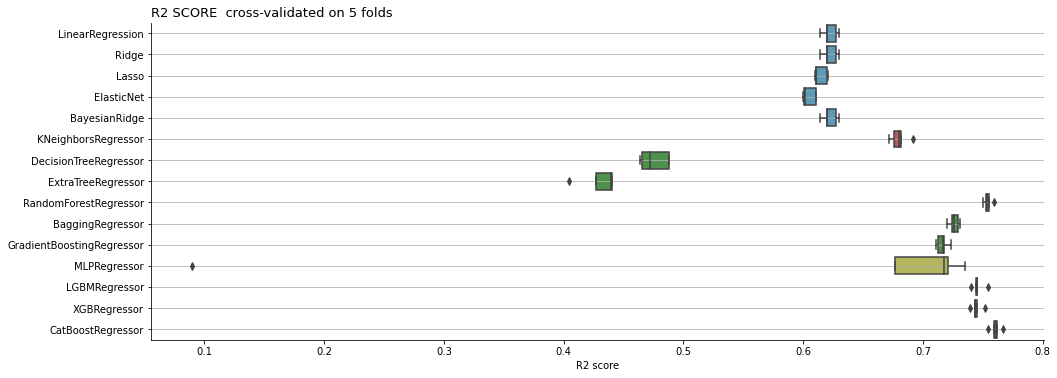

Mean of all linear-Models: 0.617
Mean of all tree-Models: 0.669
Mean of all neighbor-Models: 0.68
Mean of all neuronal-Models: 0.588


In [9]:
data = df_mpa
feature_cols = data.columns.to_list()
feature_cols.remove('size_mm')
train, test = train_test_split(data, test_size=.1)
lazy = TooLazyForRegression(save_path='lazy_report.json',
                            target_col='size_mm', feature_cols=feature_cols,fit_model_class='all',
                            sample_size='all', cross_val_splits=5, n_threads=5,
                            save_estimator=True)
lazy.generate_report(df=train)
lazy.plot_report(plot_include_time=False,plot_include_mae = False)
df_mpa_mean_r2 = lazy.mean_r2()

### 1.1 MPA log Zielvariable

Fitting CatBoostRegressor: 100%|███████████████████████████████████████████████████████| 15/15 [05:39<00:00, 22.63s/it]


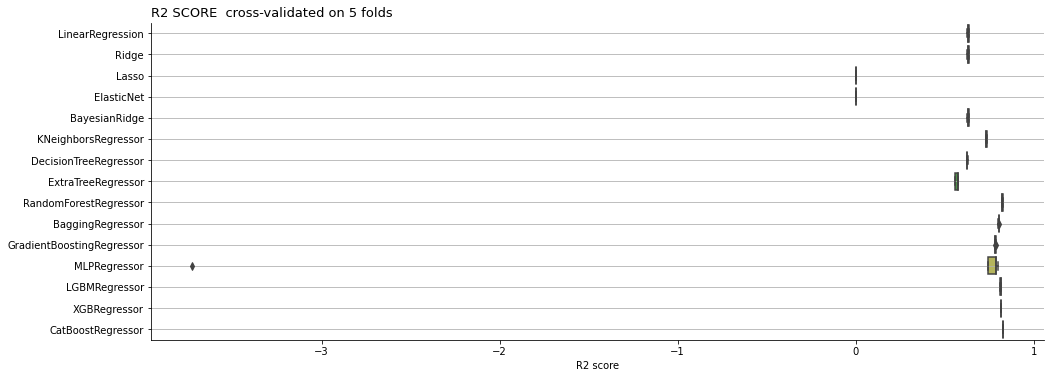

Mean of all linear-Models: 0.38
Mean of all tree-Models: 0.759
Mean of all neighbor-Models: 0.735
Mean of all neuronal-Models: -0.123


In [10]:
data = df_mpa_log_y
feature_cols = data.columns.to_list()
feature_cols.remove('size_mm')
train, test = train_test_split(data, test_size=.1)
lazy = TooLazyForRegression(save_path='lazy_report.json',
                            target_col='size_mm', feature_cols=feature_cols,fit_model_class='all',
                            sample_size='all', cross_val_splits=5, n_threads=5,
                            save_estimator=True)
lazy.generate_report(df=train)
lazy.plot_report(plot_include_time=False,plot_include_mae = False)
df_mpa_log_y_mean_r2 = lazy.mean_r2()

### 1.2 MPA log Int

Fitting CatBoostRegressor: 100%|███████████████████████████████████████████████████████| 15/15 [05:45<00:00, 23.00s/it]


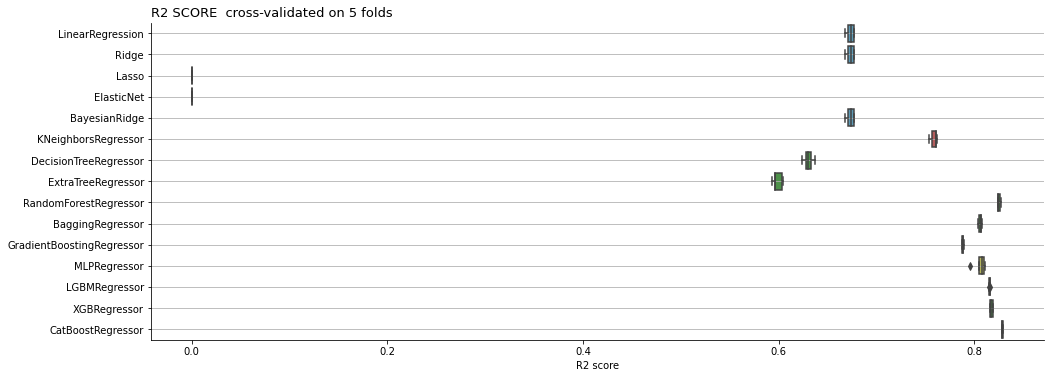

Mean of all linear-Models: 0.404
Mean of all tree-Models: 0.764
Mean of all neighbor-Models: 0.759
Mean of all neuronal-Models: 0.806


In [11]:
data = df_mpa_int_log
feature_cols = data.columns.to_list()
feature_cols.remove('size_mm')
train, test = train_test_split(data, test_size=.1)
lazy = TooLazyForRegression(save_path='lazy_report.json',
                            target_col='size_mm', feature_cols=feature_cols,fit_model_class='all',
                            sample_size='all', cross_val_splits=5, n_threads=5,
                            save_estimator=True)
lazy.generate_report(df=train)
lazy.plot_report(plot_include_time=False,plot_include_mae = False)
df_mpa_log_X_mean_r2 = lazy.mean_r2()

## 2. SPG

Fitting CatBoostRegressor: 100%|███████████████████████████████████████████████████████| 15/15 [02:10<00:00,  8.69s/it]


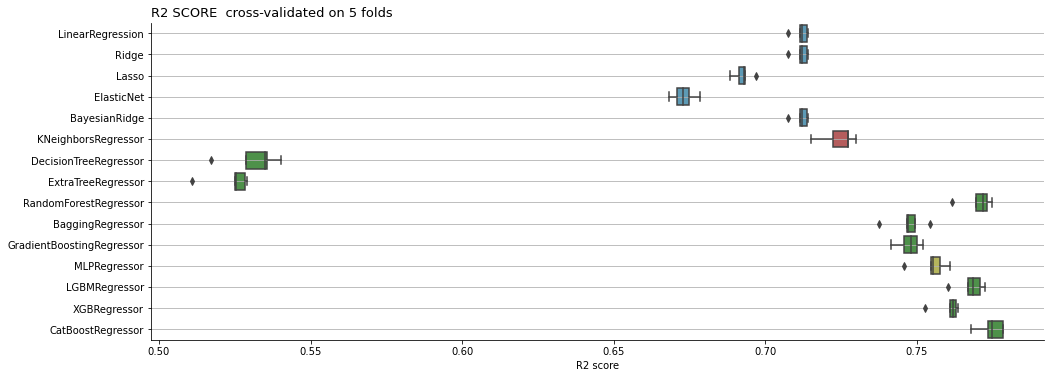

Mean of all linear-Models: 0.7
Mean of all tree-Models: 0.703
Mean of all neighbor-Models: 0.724
Mean of all neuronal-Models: 0.755


In [12]:
data = df_spg
feature_cols = data.columns.to_list()
feature_cols.remove('size_mm')
train, test = train_test_split(data, test_size=.1)
lazy = TooLazyForRegression(save_path='lazy_report.json',
                            target_col='size_mm', feature_cols=feature_cols,fit_model_class='all',
                            sample_size='all', cross_val_splits=5, n_threads=5,
                            save_estimator=True)
lazy.generate_report(df=train)
lazy.plot_report(plot_include_time=False,plot_include_mae = False)
df_spg_mean_r2 = lazy.mean_r2()

### 2.1 SPG log Zielvariable

Fitting CatBoostRegressor: 100%|███████████████████████████████████████████████████████| 15/15 [01:48<00:00,  7.25s/it]


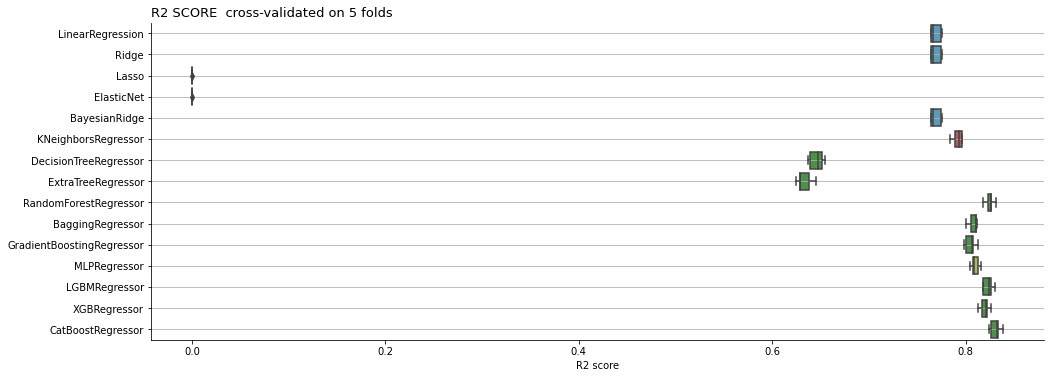

Mean of all linear-Models: 0.461
Mean of all tree-Models: 0.774
Mean of all neighbor-Models: 0.792
Mean of all neuronal-Models: 0.81


In [13]:
data = df_spg_log_y
feature_cols = data.columns.to_list()
feature_cols.remove('size_mm')
train, test = train_test_split(data, test_size=.1)
lazy = TooLazyForRegression(save_path='lazy_report.json',
                            target_col='size_mm', feature_cols=feature_cols,fit_model_class='all',
                            sample_size='all', cross_val_splits=5, n_threads=5,
                            save_estimator=True)
lazy.generate_report(df=train)
lazy.plot_report(plot_include_time=False,plot_include_mae = False)
df_spg_log_y_mean_r2 = lazy.mean_r2()

### 2.2 SPG log Int

Fitting CatBoostRegressor: 100%|███████████████████████████████████████████████████████| 15/15 [01:51<00:00,  7.42s/it]


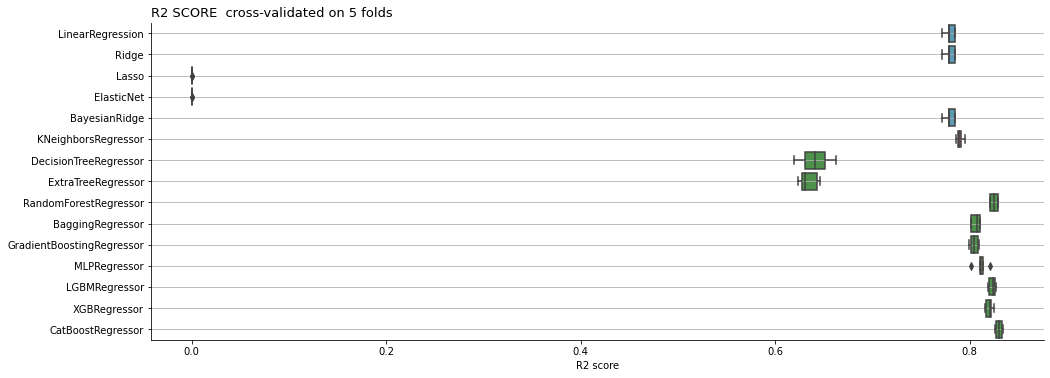

Mean of all linear-Models: 0.468
Mean of all tree-Models: 0.773
Mean of all neighbor-Models: 0.79
Mean of all neuronal-Models: 0.812


In [14]:
data = df_spg_int_log
feature_cols = data.columns.to_list()
feature_cols.remove('size_mm')
train, test = train_test_split(data, test_size=.1)
lazy = TooLazyForRegression(save_path='lazy_report.json',
                            target_col='size_mm', feature_cols=feature_cols,fit_model_class='all',
                            sample_size='all', cross_val_splits=5, n_threads=5,
                            save_estimator=True)
lazy.generate_report(df=train)
lazy.plot_report(plot_include_time=False,plot_include_mae = False)
df_spg_log_X_mean_r2 = lazy.mean_r2()

## 3. SPS

Fitting CatBoostRegressor: 100%|███████████████████████████████████████████████████████| 15/15 [00:47<00:00,  3.15s/it]


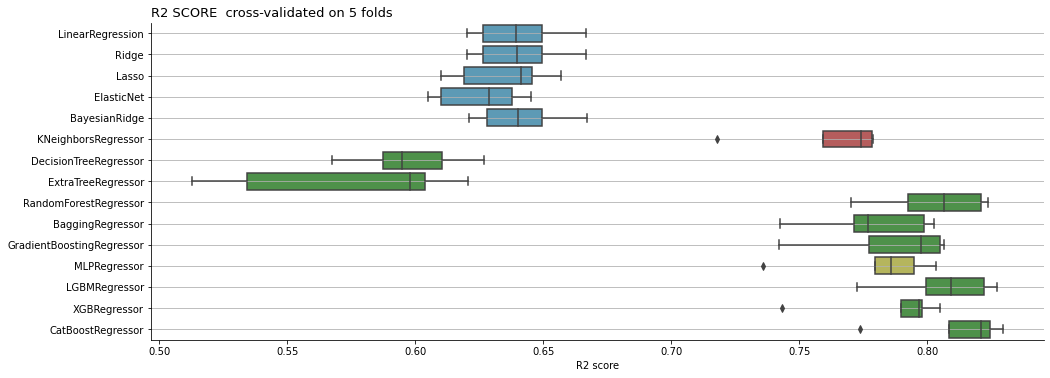

Mean of all linear-Models: 0.637
Mean of all tree-Models: 0.743
Mean of all neighbor-Models: 0.762
Mean of all neuronal-Models: 0.78


In [15]:
data = df_sps
feature_cols = data.columns.to_list()
feature_cols.remove('size_mm')
train, test = train_test_split(data, test_size=.1)
lazy = TooLazyForRegression(save_path='lazy_report.json',
                            target_col='size_mm', feature_cols=feature_cols,fit_model_class='all',
                            sample_size='all', cross_val_splits=5, n_threads=5,
                            save_estimator=True)
lazy.generate_report(df=train)
lazy.plot_report(plot_include_time=False,plot_include_mae = False)
df_sps_mean_r2 = lazy.mean_r2()

### 3.1 SPS log Zielvariable

Fitting CatBoostRegressor: 100%|███████████████████████████████████████████████████████| 15/15 [00:40<00:00,  2.73s/it]


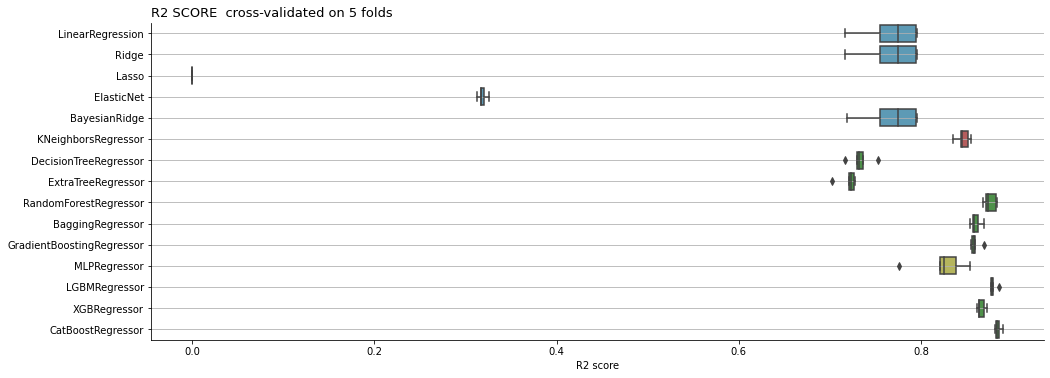

Mean of all linear-Models: 0.524
Mean of all tree-Models: 0.835
Mean of all neighbor-Models: 0.846
Mean of all neuronal-Models: 0.823


In [16]:
data = df_sps_log_y
feature_cols = data.columns.to_list()
feature_cols.remove('size_mm')
train, test = train_test_split(data, test_size=.1)
lazy = TooLazyForRegression(save_path='lazy_report.json',
                            target_col='size_mm', feature_cols=feature_cols,fit_model_class='all',
                            sample_size='all', cross_val_splits=5, n_threads=5,
                            save_estimator=True)
lazy.generate_report(df=train)
lazy.plot_report(plot_include_time=False,plot_include_mae = False)
df_sps_log_y_mean_r2 = lazy.mean_r2()

### 3.2 SPS log Int

Fitting CatBoostRegressor: 100%|███████████████████████████████████████████████████████| 15/15 [00:43<00:00,  2.92s/it]


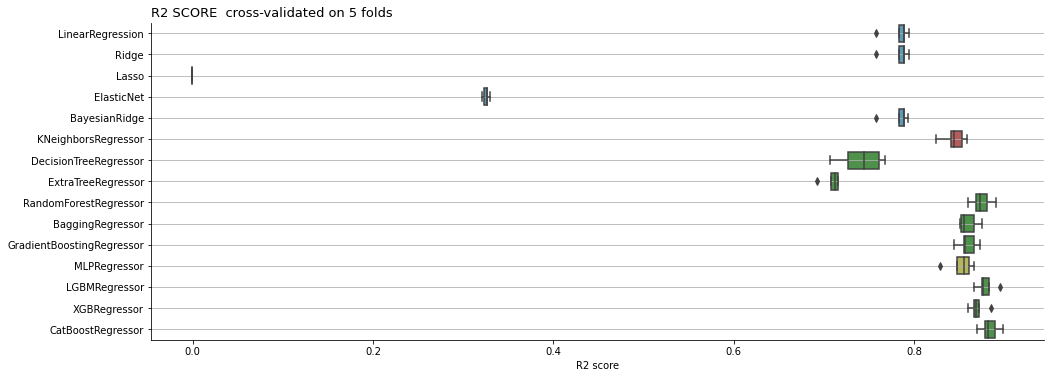

Mean of all linear-Models: 0.534
Mean of all tree-Models: 0.834
Mean of all neighbor-Models: 0.844
Mean of all neuronal-Models: 0.852


In [17]:
data = df_sps_int_log
feature_cols = data.columns.to_list()
feature_cols.remove('size_mm')
train, test = train_test_split(data, test_size=.1)
lazy = TooLazyForRegression(save_path='lazy_report.json',
                            target_col='size_mm', feature_cols=feature_cols,fit_model_class='all',
                            sample_size='all', cross_val_splits=5, n_threads=5,
                            save_estimator=True)
lazy.generate_report(df=train)
lazy.plot_report(plot_include_time=False,plot_include_mae = False)
df_sps_log_X_mean_r2 = lazy.mean_r2()

Color-Palette:
- linear = blue
- tree = green
- neighbor = red
- neuronal = yellow

## Summary

In [18]:
df_mpa_mean_r2["transformation"] = "mpa no trans"
df_mpa_log_y_mean_r2["transformation"] = "mpa y trans"
df_mpa_log_X_mean_r2["transformation"] = "mpa int trans"
df_spg_mean_r2["transformation"] = "spg no trans"
df_spg_log_y_mean_r2["transformation"] = "spg y trans"
df_spg_log_X_mean_r2["transformation"] = "spg int trans"
df_sps_mean_r2["transformation"] = "sps no trans"
df_sps_log_y_mean_r2["transformation"] = "sps y trans"
df_sps_log_X_mean_r2["transformation"] = "sps int trans"

In [26]:
frames = [df_mpa_mean_r2,df_mpa_log_y_mean_r2,df_mpa_log_X_mean_r2,df_spg_mean_r2,df_spg_log_y_mean_r2,df_spg_log_X_mean_r2,df_sps_mean_r2,df_sps_log_y_mean_r2,df_sps_log_X_mean_r2]
result = pd.concat(frames)

In [64]:
result.to_csv(r'result.csv')

In [27]:
mpa_results = result[result['transformation'].str.contains("mpa")]
spg_results = result[result['transformation'].str.contains("spg")]
sps_results = result[result['transformation'].str.contains("sps")]

In [28]:
#report_sum_mean = report.groupby(['model']).mean()
#report_sum_mean=report_sum_mean.reindex(plot_order)
#report_sum_mean['model'] = report_sum_mean.index
#report_sum_mean.reset_index(drop=True, inplace=True)
#report_sum_mean=report_sum_mean[["model","score"]]
#report_sum_mean

In [50]:
messsystem_frames = [df_mpa_log_y_mean_r2,df_spg_log_y_mean_r2,df_sps_log_y_mean_r2]
messsystem_result = pd.concat(messsystem_frames)
messsystem_result = messsystem_result.drop([232])

In [51]:
messsystem_result['transformation'] = messsystem_result['transformation'].replace(['mpa y trans','spg y trans','sps y trans'],['mpa','spg','sps'])

In [55]:
messsystem_result = messsystem_result[messsystem_result.model != "Lasso"]
messsystem_result = messsystem_result[messsystem_result.model != "ElasticNet"]

In [65]:
messsystem_result.to_csv(r'messsystem_result.csv')

In [3]:
result = pd.read_csv('result.csv')
messsystem_result = pd.read_csv('messsystem_result.csv')

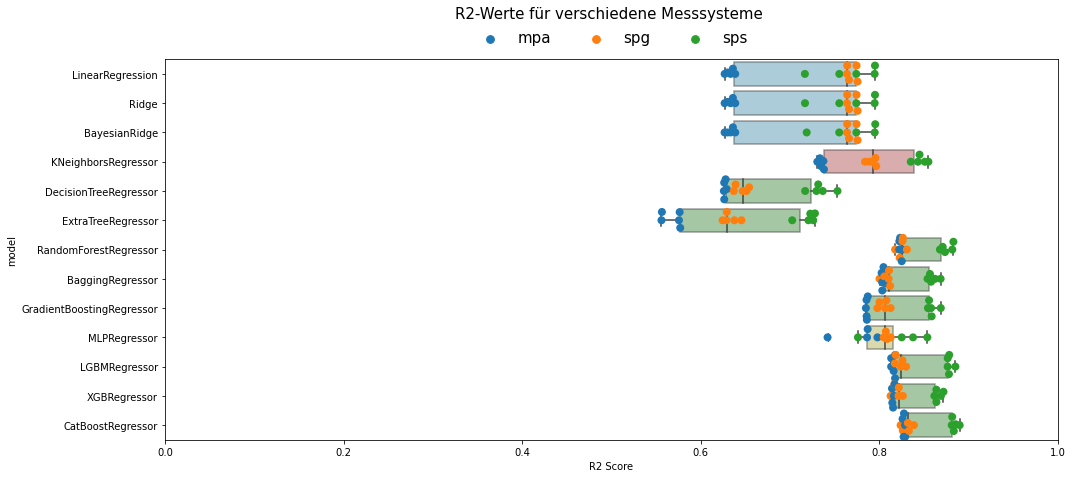

In [20]:
plot_data = messsystem_result
fig = plt.subplots(figsize=(16, 7))
colors = ["#4EA0C4","#4EA0C4","#4EA0C4","#C44E4E","#449D3E","#449D3E","#449D3E","#449D3E","#449D3E","#C4C44E","#449D3E","#449D3E","#449D3E"]
p =sns.boxplot(data=plot_data,x=plot_data["score"],y=plot_data["model"],palette=colors, boxprops=dict(alpha=.5))
P=sns.swarmplot(data=plot_data,x=plot_data["score"],y=plot_data["model"],hue=plot_data["transformation"],s=8)
p.legend(loc="lower center", bbox_to_anchor=(0.5, 1.0), ncol=3, title=None, frameon=False,fontsize=15)
plt.title("R2-Werte für verschiedene Messsysteme \n\n",fontsize=15)
plt.xlabel("R2 Score")
plt.xlim([0,1])
plt.show()

In [33]:
mpa_results = mpa_results.drop([232])

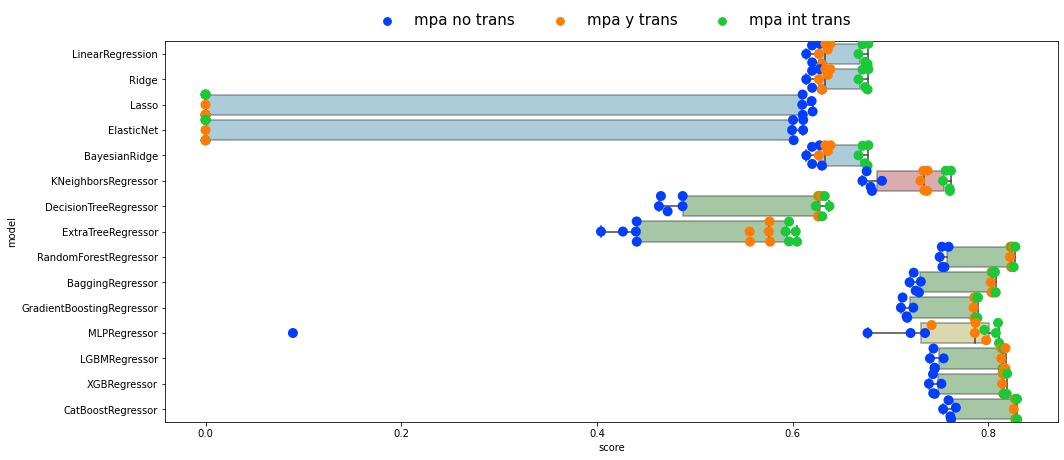

In [34]:
plot_data = mpa_results
fig = plt.subplots(figsize=(16, 7))
colors = ["#4EA0C4", "#4EA0C4", "#4EA0C4","#4EA0C4","#4EA0C4","#C44E4E","#449D3E","#449D3E","#449D3E","#449D3E","#449D3E","#C4C44E","#449D3E","#449D3E","#449D3E"]
p =sns.boxplot(data=plot_data,x=plot_data["score"],y=plot_data["model"],palette=colors, boxprops=dict(alpha=.5))
P=sns.swarmplot(data=plot_data,x=plot_data["score"],y=plot_data["model"],hue=plot_data["transformation"],s=10,palette = "bright")
p.legend(loc="lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False,fontsize=15)
plt.show()

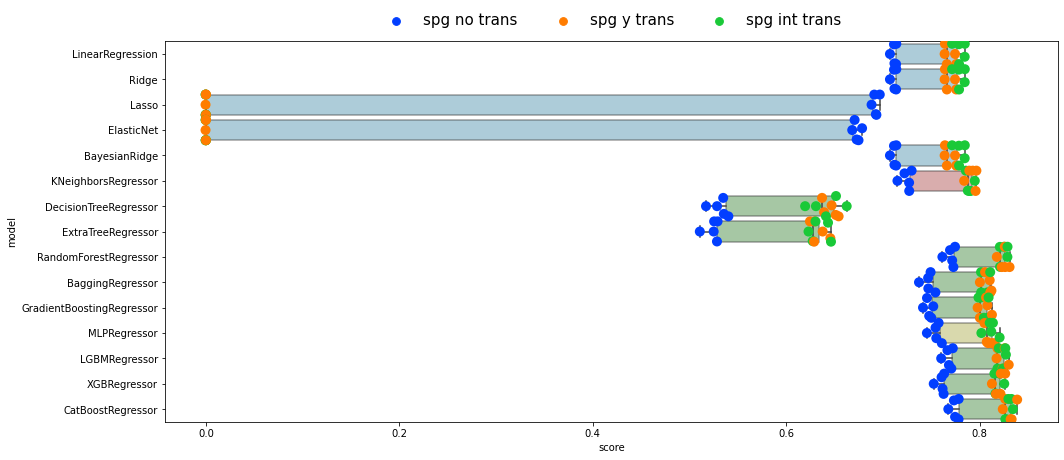

In [24]:
plot_data = spg_results
fig = plt.subplots(figsize=(16, 7))
colors = ["#4EA0C4", "#4EA0C4", "#4EA0C4","#4EA0C4","#4EA0C4","#C44E4E","#449D3E","#449D3E","#449D3E","#449D3E","#449D3E","#C4C44E","#449D3E","#449D3E","#449D3E"]
p =sns.boxplot(data=plot_data,x=plot_data["score"],y=plot_data["model"],palette=colors, boxprops=dict(alpha=.5))
P=sns.swarmplot(data=plot_data,x=plot_data["score"],y=plot_data["model"],hue=plot_data["transformation"],s=10,palette = "bright")
p.legend(loc="lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False,fontsize=15)
plt.show()

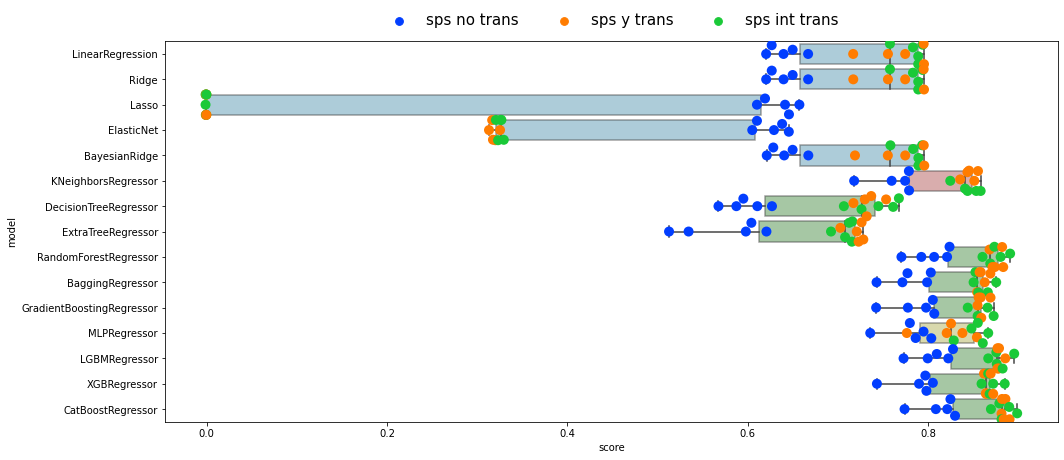

In [25]:
plot_data = sps_results
fig = plt.subplots(figsize=(16, 7))
colors = ["#4EA0C4", "#4EA0C4", "#4EA0C4","#4EA0C4","#4EA0C4","#C44E4E","#449D3E","#449D3E","#449D3E","#449D3E","#449D3E","#C4C44E","#449D3E","#449D3E","#449D3E"]
p =sns.boxplot(data=plot_data,x=plot_data["score"],y=plot_data["model"],palette=colors, boxprops=dict(alpha=.5))
P=sns.swarmplot(data=plot_data,x=plot_data["score"],y=plot_data["model"],hue=plot_data["transformation"],s=10,palette = "bright")
p.legend(loc="lower center", bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False,fontsize=15)
plt.show()